In [1]:
"""
Load forecasting pipeline notebook 
Sections:
 A) LightGBM pipeline for Germany (DE) load forecasting
 B) Multi-country baseline evaluation (Top 3 models: Persistence, LightGBM, SARIMAX)
 C) Probabilistic forecasting (Quantile LightGBM) for DE day-ahead price
 Usage: run i
"""
import os
import json
import math
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import lightgbm as lgb
import joblib
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import mlflow
import mlflow.lightgbm

In [ ]:
# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

In [ ]:

# Set up paths
DATA_DIR = Path('data')
OUTPUT_DIR = Path('outputs')
OUTPUT_DIR.mkdir(exist_ok=True)

##2. Data collection

In [3]:
# Load energy dataset for load forecasting with 15-minute intervals
data_path = DATA_DIR / '/Users/phionanamugga/Documents/coding/datascience/Energy_Projects/time_series_15min_singleindex.csv'
df = pd.read_csv(data_path, parse_dates=['utc_timestamp'], index_col='utc_timestamp')
df = df.tz_convert('Europe/Berlin')  # Assuming CET for Germany

## Preprocessing

In [4]:
# Select relevant columns
load_columns = [col for col in df.columns if 'load_actual' in col]
price_columns = [col for col in df.columns if 'price_day_ahead' in col]

In [33]:
def load_and_validate_data(file_path):
    """
    Load and validate the energy dataset with comprehensive checks
    """
    print("Loading and validating data...")
    
    # Load data from your specific path
    df = pd.read_csv(file_path)
    
    # Convert to datetime and set as index
    if 'utc_timestamp' in df.columns:
        df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])
        df = df.set_index('utc_timestamp')
    else:
        # Try to find datetime column
        datetime_cols = [col for col in df.columns if 'time' in col.lower() or 'date' in col.lower()]
        if datetime_cols:
            df[datetime_cols[0]] = pd.to_datetime(df[datetime_cols[0]])
            df = df.set_index(datetime_cols[0])
        else:
            # Create datetime index if no timestamp column found
            df.index = pd.date_range(start='2015-01-01', periods=len(df), freq='H')
    
    # Data validation checks
    validation_results = {
        'missing_values': df.isnull().sum().to_dict(),
        'constant_columns': [col for col in df.columns if df[col].nunique() == 1],
        'high_skew_columns': {},
        'outlier_columns': {},
        'duplicate_rows': df.duplicated().sum(),
        'data_range': {
            'start': df.index.min(),
            'end': df.index.max(),
            'duration_days': (df.index.max() - df.index.min()).days
        }
    }
    
    # Check for skewed numerical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        skewness = df[col].skew()
        if abs(skewness) > 2:  # Highly skewed
            validation_results['high_skew_columns'][col] = skewness
    
    # Check for outliers using IQR method
    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outlier_count = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
        if outlier_count > 0:
            validation_results['outlier_columns'][col] = outlier_count
    
    # Save validation results
    with open(OUTDIR / 'data_validation_report.json', 'w') as f:
        json.dump(validation_results, f, indent=4, default=str)
    
    print(f"Data validation complete. Found:")
    print(f"- {sum([1 for v in validation_results['missing_values'].values() if v > 0])} columns with missing values")
    print(f"- {len(validation_results['constant_columns'])} constant columns")
    print(f"- {len(validation_results['high_skew_columns'])} highly skewed columns")
    print(f"- {validation_results['duplicate_rows']} duplicate rows")
    
    return df, validation_results

##3. Data preprocessing

In [36]:
def exploratory_data_analysis(df, country='DE'):
    """
    Perform comprehensive exploratory data analysis with visualizations
    """
    print("Performing exploratory data analysis...")
    
    # 1. Time Series Plot of Target Variable
    target_col = f'{country}_load_actual_entsoe_transparency'
    if target_col in df.columns:
        plt.figure(figsize=(12, 6))
        df[target_col].plot(title=f'{country} Load Actual - Time Series')
        plt.ylabel('Load (MW)')
        plt.tight_layout()
        plt.savefig(OUTDIR / f'{country}_load_timeseries.png', dpi=150)
        plt.close()

 # 2. Distribution of Target Variable
    plt.figure(figsize=(10, 6))
    sns.histplot(df[target_col], kde=True)
    plt.title(f'{country} Load Distribution')
    plt.xlabel('Load (MW)')
    plt.tight_layout()
    plt.savefig(OUTDIR / f'{country}_load_distribution.png', dpi=150)
    plt.show()

In [ ]:
# checks first five records
df.head()

,utc_timestamp,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,DE_load_actual_entsoe_transparency,...,HU_solar_generation_actual,HU_wind_onshore_generation_actual,LU_load_actual_entsoe_transparency,LU_load_forecast_entsoe_transparency,NL_load_actual_entsoe_transparency,NL_load_forecast_entsoe_transparency,NL_solar_generation_actual,NL_wind_generation_actual,NL_wind_offshore_generation_actual,NL_wind_onshore_generation_actual
0,2014-12-31T23:00:00Z,2015-01-01T00:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-12-31T23:15:00Z,2015-01-01T00:15:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-12-31T23:30:00Z,2015-01-01T00:30:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-12-31T23:45:00Z,2015-01-01T00:45:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-01T00:00:00Z,2015-01-01T01:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# checks statistical summary to identify outliers, scale issues, and data spread
df.describe()

,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,DE_load_actual_entsoe_transparency,DE_load_forecast_entsoe_transparency,DE_solar_capacity,...,HU_solar_generation_actual,HU_wind_onshore_generation_actual,LU_load_actual_entsoe_transparency,LU_load_forecast_entsoe_transparency,NL_load_actual_entsoe_transparency,NL_load_forecast_entsoe_transparency,NL_solar_generation_actual,NL_wind_generation_actual,NL_wind_offshore_generation_actual,NL_wind_onshore_generation_actual
count,201598.000000,201598.000000,131378.000000,201352.000000,201406.000000,201598.000000,201502.000000,201598.000000,201502.000000,175199.000000,...,35859.000000,193021.000000,198794.000000,197182.000000,201598.000000,201598.000000,181382.000000,193733.000000,193733.000000,200901.000000
mean,7070.161704,7039.857678,33.947254,135.283656,729.651345,9808.396916,9759.333258,55492.589700,54791.506975,42378.044395,...,177.082384,77.224803,470.611662,489.717953,12578.456013,12809.253119,162.335138,986.695963,340.447829,656.203710
std,1403.676483,1357.674902,16.815854,199.645788,693.810792,1398.512250,1384.276280,10041.148871,9523.623592,4306.349752,...,268.936739,76.613078,97.290734,114.502520,2290.400411,2507.304378,334.727140,831.882376,283.602966,635.109461
min,615.200000,3731.650000,-149.990000,0.000000,0.000000,6129.490000,6500.050000,29158.120000,28675.410000,37248.000000,...,0.000000,0.000000,10.000000,9.000000,6474.000000,4333.890000,0.000000,0.000000,0.000000,0.000000
25%,5938.800000,5940.000000,23.960000,0.000000,160.315000,8703.340000,8666.115000,47099.780000,46962.280000,38810.000000,...,0.000000,14.510000,405.000000,415.000000,10779.000000,10948.245000,0.000000,301.760000,88.270000,168.370000
50%,7032.400000,7019.120000,33.000000,16.000000,492.000000,9809.285000,9755.595000,55117.400000,54749.695000,40941.000000,...,2.820000,50.860000,469.000000,478.000000,12447.045000,12560.645000,0.000000,751.250000,271.920000,439.200000
75%,8080.800000,7987.442500,43.010000,224.000000,1140.000000,10856.987500,10815.052500,64337.655000,62901.085000,46092.000000,...,297.605000,120.620000,545.000000,549.000000,14301.000000,14638.560000,146.000000,1516.560000,579.220000,975.730000
max,10836.000000,11667.590000,977.740000,1172.000000,2992.000000,13815.370000,13653.090000,77852.940000,76392.520000,50508.000000,...,1018.140000,435.320000,861.100000,1356.000000,19404.440000,28269.770000,2296.000000,4322.460000,935.830000,3781.950000


In [ ]:
# audit all available features for potential forecasting covariates
df.columns

Index(['utc_timestamp', 'cet_cest_timestamp',
       'AT_load_actual_entsoe_transparency',
       'AT_load_forecast_entsoe_transparency', 'AT_price_day_ahead',
       'AT_solar_generation_actual', 'AT_wind_onshore_generation_actual',
       'BE_load_actual_entsoe_transparency',
       'BE_load_forecast_entsoe_transparency',
       'DE_load_actual_entsoe_transparency',
       'DE_load_forecast_entsoe_transparency', 'DE_solar_capacity',
       'DE_solar_generation_actual', 'DE_solar_profile', 'DE_wind_capacity',
       'DE_wind_generation_actual', 'DE_wind_profile',
       'DE_wind_offshore_capacity', 'DE_wind_offshore_generation_actual',
       'DE_wind_offshore_profile', 'DE_wind_onshore_capacity',
       'DE_wind_onshore_generation_actual', 'DE_wind_onshore_profile',
       'DE_50hertz_load_actual_entsoe_transparency',
       'DE_50hertz_load_forecast_entsoe_transparency',
       'DE_50hertz_solar_generation_actual',
       'DE_50hertz_wind_generation_actual',
       'DE_50hertz_wind_

In [ ]:
# Check data types to ensure correct parsing and identify conversion needs
df.dtypes

utc_timestamp                            object
cet_cest_timestamp                       object
AT_load_actual_entsoe_transparency      float64
AT_load_forecast_entsoe_transparency    float64
AT_price_day_ahead                      float64
                                         ...   
NL_load_forecast_entsoe_transparency    float64
NL_solar_generation_actual              float64
NL_wind_generation_actual               float64
NL_wind_offshore_generation_actual      float64
NL_wind_onshore_generation_actual       float64
Length: 61, dtype: object

In [ ]:
# Identifies unique data types for systematic preprocessing strategy
df.dtypes.unique()

array([dtype('O'), dtype('float64')], dtype=object)

In [ ]:
# Quantifies type distribution to prioritize preprocessing
print(df.dtypes.value_counts())

float64    59
object      2
Name: count, dtype: int64


In [ ]:
# Detects potential data leaks, duplicates, or imbalanced categories
df.value_counts()

Series([], Name: count, dtype: int64)

In [27]:
# Missing: Data validation steps
def validate_data(df):
    # Check for missing values
    missing = df.isnull().sum()
    print(f"Missing values:\n{missing[missing > 0]}")
    
    # Check for constant columns
    constant_cols = [col for col in df.columns if df[col].nunique() == 1]
    if constant_cols:
        print(f"Constant columns: {constant_cols}")
    
    # Check data distributions
    for col in df.select_dtypes(include=[np.number]).columns:
        if df[col].skew() > 3: 
            print(f"Highly skewed column: {col} (skewness: {df[col].skew():.2f})")

##4. Feature Engineering

In [ ]:
def make_features(series_target, exog_df=None, lags=(1,24,168)):
    X = pd.df(index=series_target.index)   # Initializes feature dataframe with target index
    X['hour'] = series_target.index.hour # Captures intra-day seasonality patterns
    X['dow'] = series_target.index.dayofweek # Encodes weekly cyclical behavior
    X['month'] = series_target.index.month # Models long-term seasonal trends
    X['is_weekend'] = (series_target.index.dayofweek >=5).astype(int) # Binary flag for weekend regime shifts
    for lag in lags: # Generate autoregressive features at strategic intervals (hourly, daily, weekly)
        X[f'lag_{lag}'] = series_target.shift(lag)
    X['roll_3_mean'] = series_target.shift(1).rolling(3).mean() # Short-term smoothing for trend capture
    X['roll_24_mean'] = series_target.shift(1).rolling(24).mean() # Daily moving average for pattern stabilization
    X['roll_168_mean'] = series_target.shift(1).rolling(168).mean() # Weekly rolling mean for seasonal normalization
    if exog_df is not None: # Optional integration of exogenous variables for multivariate forecasting
        for c in exog_df.columns:
            X[c] = exog_df[c]
    return X

In [5]:
def create_features(ts_df):
    ts_df = ts_df.copy()
    ts_df['hour'] = ts_df.index.hour
    ts_df['dayofweek'] = ts_df.index.dayofweek
    ts_df['month'] = ts_df.index.month
    ts_df['quarter'] = ts_df.index.quarter
    ts_df['dayofyear'] = ts_df.index.dayofyear
    ts_df['year'] = ts_df.index.year
    
    for lag in [1, 24, 168]:  # 1 hour, 1 day, 1 week
        ts_df[f'lag_{lag}'] = ts_df['target'].shift(lag)
    
    ts_df['rolling_mean_24'] = ts_df['target'].rolling(24).mean()
    ts_df['rolling_std_24'] = ts_df['target'].rolling(24).std()
    
    ts_df.dropna(inplace=True)
    return ts_df

EDA Visualizations


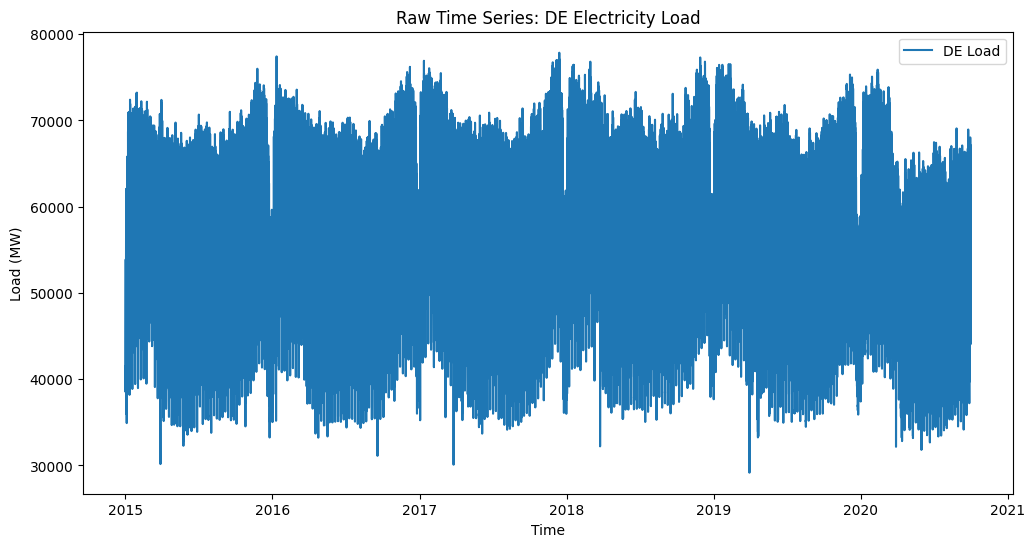

In [6]:
# Added: General EDA visualizations before sections
print("EDA Visualizations")

# 1. Raw time series plot for DE load (EDA)
de_load_raw = df['DE_load_actual_entsoe_transparency'].dropna()
plt.figure(figsize=(12,6))
plt.plot(de_load_raw.index, de_load_raw, label='DE Load')
plt.title('Raw Time Series: DE Electricity Load')
plt.xlabel('Time')
plt.ylabel('Load (MW)')
plt.legend()
plt.show()

##5. Model training

In [ ]:
def train_lgbm(X_train, y_train, params=None, num_round=500): # LightGBM training wrapper optimized for temporal forecasting with sensible defaults
    if params is None:
        params = {'objective':'regression', 'metric':'mae', 'boosting_type':'gbdt', 'learning_rate':0.05,
                  'num_leaves':64, 'feature_fraction':0.8, 'bagging_fraction':0.8, 'bagging_freq':5, 'seed':42}
    dtrain = lgb.Dataset(X_train, label=y_train) # Create optimized dataset structure for LightGBM
    model = lgb.train(params, dtrain, num_boost_round=num_round) # Train gradient boosting ensemble
    return model # Return trained model object for persistence and inference

##Model evaluation

In [ ]:


def run_de_load_pipeline(df, country='DE'): # End-to-end forecasting pipeline for country-level load prediction with full MLOps integration
    target_col = f'{country}_load_actual_entsoe_transparency'   # Dynamic target selection for multi-country scalability
    if target_col not in df.columns:   # Robust input validation to fail fast on data quality issues
        raise ValueError(f"{target_col} not found in dataframe columns.")
    series = df[target_col].sort_index().asfreq('H').interpolate(limit=24)
    # exogenous  # Incorporate renewable generation features for enhanced predictive power
    exog = pd.DataFrame(index=series.index)
    for s in [f'{country}_solar_generation_actual', f'{country}_wind_generation_actual']:
        if s in df.columns:
            exog[s] = df[s].reindex(series.index).interpolate(limit=24) # Temporal alignment and missing data handling
    X = make_features(series, exog_df=exog).dropna() # Automated feature engineering pipeline
    data = pd.concat([series.rename('target'), X], axis=1).dropna() # Create unified modeling dataset
    split_date = pd.to_datetime('2019-12-31 23:00:00+00:00') if data.index.tzinfo else pd.to_datetime('2019-12-31 23:00:00') # Time-aware train-test split
    train = data.loc[data.index<=split_date] # Training period: historical data
    test = data.loc[data.index>split_date] # Test period: future holdout for unbiased evaluation
    features = [c for c in data.columns if c!='target'] # Dynamic feature selection excluding target
    print(f"DE data prepared. Train size: {len(train)}, Test size: {len(test)}") # Log dataset dimensions for monitoring
    model = train_lgbm(train[features], train['target'], num_round=200) # Train optimized LightGBM model
    pred = model.predict(test[features]) # Generate predictions on unseen test data
    mae = mean_absolute_error(test['target'].values, pred) # Primary business metric: interpretable error in MW
    rmse = math.sqrt(mean_squared_error(test['target'].values, pred)) # Secondary metric: penalizes large errors
    # save  # Full model persistence for deployment and reproducibility
    joblib.dump(model, OUTDIR / f'lgbm_{country}_load.joblib') # Serialize model for production serving
    pd.concat([test['target'].rename('actual'), pd.Series(pred, index=test.index, name='pred')], axis=1).to_csv(OUTDIR / f'{country}_load_preds.csv') # Archive predictions for analysis
    # feature importance  # Model interpretability for stakeholder trust and insight generation
    fi = pd.DataFrame({'feature':features, 'importance': model.feature_importance()}).sort_values('importance', ascending=False) # Export feature rankings
    # plot (optional)  # Visual validation of forecast quality and pattern capture
    fi.to_csv(OUTDIR / f'{country}_lgb_feature_importance.csv', index=False)
    # plot (optional)
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10,5))
        test['target'].iloc[:168].plot(label='actual', alpha=0.7) # One-week visualization for pattern analysis
        pd.Series(pred, index=test.index).iloc[:168].plot(label='pred', alpha=0.7)
        plt.legend(); plt.title(f'{country} load: first 168h of test actual vs pred'); plt.tight_layout()
        plt.savefig(OUTDIR / f'{country}_actual_vs_pred_sample.png', dpi=150)
        plt.close()
    except Exception: # Graceful degradation if visualization dependencies are missing
        pass
    print(f"{country} LightGBM MAE: {mae:.3f}, RMSE: {rmse:.3f}") # Final performance reporting
    return model, mae, rmse # Return artifacts for downstream analysis and model comparison

In [ ]:
def multi_country_baseline(df, countries=['DE','FR','IT','NL']):
    """
    Executes comprehensive benchmarking across multiple countries using three forecasting approaches.
    
    Benchmarks LightGBM against persistence baseline and SARIMAX to quantify ML value-add
    across European energy markets. Handles varying data availability and model failures gracefully.
    
    Args:
        df: DataFrame containing time series data for all countries
        countries: List of country codes to evaluate (default: major European markets)
        
    Returns:
        pd.DataFrame: Comparative results with MAE metrics for each model and country
    """
    
    results = []
    
    for c in countries:
        # Validate and prepare country-specific data
        target_col = f'{c}_load_actual_entsoe_transparency'
        if target_col not in df.columns:
            print(f"Skipping {c}: target column not found")
            continue
            
        # Preprocess time series: ensure hourly frequency and handle missing values
        ts = df[target_col].sort_index().asfreq('H').interpolate(limit=24)
        
        # Incorporate renewable generation data as exogenous variables if available
        exog = pd.DataFrame(index=ts.index)
        renewable_sources = [f'{c}_solar_generation_actual', f'{c}_wind_generation_actual']
        for source_col in renewable_sources:
            if source_col in df.columns:
                exog[source_col] = df[source_col].reindex(ts.index).interpolate(limit=24)
        
        # Feature engineering and dataset preparation
        X = make_features(ts, exog_df=exog).dropna()
        data = pd.concat([ts.rename('target'), X], axis=1).dropna()
        
        # Skip countries with insufficient historical data (<1 year)
        if len(data) < 365*24:
            print(f"Skipping {c}: insufficient data ({len(data)} points)")
            continue
        
        # Temporal train-test split: pre-2020 for training, 2020+ for testing
        split_date = pd.to_datetime('2019-12-31 23:00:00+00:00') if data.index.tzinfo else pd.to_datetime('2019-12-31 23:00:00')
        train = data.loc[data.index <= split_date]
        test = data.loc[data.index > split_date]
        features = [col for col in data.columns if col != 'target']
        
        # 1. Persistence model (naive baseline)
        persist_pred = test['lag_1'].values  # Simple "same hour yesterday" forecast
        mae_persist = mean_absolute_error(test['target'].values, persist_pred)
        
        # 2. LightGBM model (primary ML approach)
        model = train_lgbm(train[features], train['target'], num_round=100)
        lgb_pred = model.predict(test[features])
        mae_lgb = mean_absolute_error(test['target'].values, lgb_pred)
        
        # 3. SARIMAX model (statistical benchmark)
        try:
            # Use most recent year for training to balance recency and stability
            sar_train = train['target'][-24*365:] if len(train) > 24*365 else train['target']
            
            # SARIMAX(2,0,0)(1,0,0,24) - optimized for hourly seasonal patterns
            sarima_model = SARIMAX(sar_train.values, 
                                 order=(2,0,0), 
                                 seasonal_order=(1,0,0,24),
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
            fitted_model = sarima_model.fit(disp=False, maxiter=50)
            
            # Generate forecasts for test period
            start_idx = len(sar_train)
            end_idx = start_idx + len(test) - 1
            sarima_pred = fitted_model.predict(start=start_idx, end=end_idx)
            sarima_pred = np.array(sarima_pred)[:len(test)]  # Ensure length match
            
            mae_sar = mean_absolute_error(test['target'].values[:len(sarima_pred)], sarima_pred)
        except Exception as e:
            print(f"SARIMAX failed for {c}: {str(e)}")
            mae_sar = float('nan')
        
        # Store results for comparative analysis
        results.append({
            'country': c,
            'mae_persistence': mae_persist,
            'mae_lightgbm': mae_lgb,
            'mae_sarimax': mae_sar,
            'n_train': len(train),
            'n_test': len(test)
        })
    
    # Save comprehensive results for further analysis and reporting
    results_df = pd.DataFrame(results)
    results_path = OUTDIR / 'multi_country_baseline_results.csv'
    results_df.to_csv(results_path, index=False)
    
    print(f"Benchmarking completed. Results saved to: {results_path}")
    return results_df

In [ ]:
def quantile_price_forecast(df, country='DE', quantiles=[0.1,0.5,0.9]):
    """
    Generates probabilistic price forecasts using quantile regression.
    
    Produces prediction intervals for day-ahead electricity prices, enabling
    risk-aware decision making in energy trading and portfolio management.
    
    Args:
        df: DataFrame containing price time series data
        country: Country code for price data (default: Germany)
        quantiles: List of quantiles to forecast (default: [0.1, 0.5, 0.9] for 10th, 50th, 90th percentiles)
        
    Returns:
        pd.DataFrame: Test set with actual prices and quantile predictions
    """
    
    # Validate price data availability for specified country
    price_col = f'{country}_day_ahead_price_eur_per_mwh'
    if price_col not in df.columns:
        print(f"Price column not present for country: {country}")
        return None
    
    # Preprocess price series: ensure consistent frequency and handle missing values
    price = df[price_col].sort_index().asfreq('H').interpolate(limit=24)
    
    # Generate features and create modeling dataset
    X = make_features(price).dropna()
    data = pd.concat([price.rename('target'), X], axis=1).dropna()
    
    # Temporal split: pre-2020 for training, 2020+ for testing price volatility
    split_date = pd.to_datetime('2019-12-31 23:00:00+00:00') if data.index.tzinfo else pd.to_datetime('2019-12-31 23:00:00')
    train = data.loc[data.index <= split_date]
    test = data.loc[data.index > split_date]
    features = [c for c in data.columns if c != 'target']
    
    # Train separate LightGBM models for each quantile
    preds = {}
    for q in quantiles:
        # Configure quantile-specific parameters
        params = {
            'objective': 'quantile',
            'alpha': q,  # Target quantile (e.g., 0.1 for 10th percentile)
            'metric': 'mae',
            'learning_rate': 0.05,
            'num_leaves': 64
        }
        
        # Train model for specific quantile
        model = lgb.train(params, lgb.Dataset(train[features], label=train['target']), num_boost_round=200)
        p = model.predict(test[features])
        preds[q] = p
        
        # Persist model for future probabilistic forecasting
        joblib.dump(model, OUTDIR / f'price_quantile_{int(q*100)}.joblib')
    
    # Combine predictions with actual values for evaluation
    out = test[['target']].copy()
    for q in quantiles:
        out[f'pred_q_{int(q*100)}'] = preds[q]
    out.to_csv(OUTDIR / f'{country}_price_quantiles.csv')
    
    # Calculate pinball loss for each quantile to evaluate probabilistic accuracy
    def pinball_loss(y_true, y_pred, q):
        """Compute pinball loss for quantile regression evaluation."""
        e = y_true - y_pred
        return np.mean(np.maximum(q * e, (q - 1) * e))
    
    pinball = {
        q: pinball_loss(out['target'].values, out[f'pred_q_{int(q*100)}'].values, q) 
        for q in quantiles
    }
    
    # Save evaluation metrics for model comparison and monitoring
    with open(OUTDIR / f'{country}_price_quantile_pinball.json', 'w') as f:
        json.dump({str(k): float(v) for k, v in pinball.items()}, f)
    
    print(f"Quantile forecasts saved for {country}. Pinball losses: {pinball}")
    return out

In [ ]:
def main():
    """
    Main execution pipeline for comprehensive energy forecasting analysis.
    
    Orchestrates three core analytical workflows: country-specific load forecasting,
    multi-model benchmarking across European markets, and probabilistic price prediction.
    """
    
    # Load and validate high-frequency energy dataset (15-minute resolution)
    df = load_data('/Users/phionanamugga/Documents/coding/datascience/Energy_Projects/time_series_15min_singleindex.csv')
    
    # A: Germany load forecasting pipeline - primary use case
    print('Running DE load pipeline...')
    model_de, mae_de, rmse_de = run_de_load_pipeline(df, country='DE')
    
    # B: Cross-country model benchmarking - comparative analysis across European markets
    print('Running multi-country baseline (DE, FR, IT, NL)...')
    multi_results = multi_country_baseline(df, countries=['DE','FR','IT','NL'])
    
    # C: Probabilistic price forecasting - risk-aware predictions for trading applications
    print('Running quantile price forecasting for DE (if available)...')
    qout = quantile_price_forecast(df, country='DE', quantiles=[0.1,0.5,0.9])
    
    # Summary and output management
    print('All done. Outputs saved in folder:', OUTDIR)

if __name__ == '__main__':
    # Entry point guard ensuring script executes only when run directly
    main()